In [1]:
# Kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random
from catboost import CatBoostClassifier, Pool

In [2]:
def sayac_model_ohe(df):
    SAYAC_MODEL_DICT = {'LUN10-B' : "%20", 'AEL.TF.16-2' : "%20", 'LUN23 TF' : "%20", 'EC058MCT' : '%6-8', 
                        'LSM-35': '%6-8', 'VEM-T5100DB0E': '%6-8', 'T510.2251': '%6-8', 'M500.2211': '%6-8',
                        'LUN10' : '%3-5', 'EC058MBW' : '%3-5', 'VEM-M580DB0E' : '%3-5', 'VEM-M580DB0' :  '%3-5',
                        'LUN21' :  '%3-5', 'EC25TPA3CHB' :  '%3-5', 'VEM-T5100DB0' :  '%3-5', 'LUN1' : '%1-3', 
                        'EC018MBW': '%1-3', 'AEL.MF.07': '%1-3', 'EC15ATBW': '%1-3', 'M500.2251': '%1-3', 
                        'M310.2218': '%1-3', 'M550.2251': '%1-3', 'EC11ATBW': '%1-3', 'AEL.TF.16': '%1-3','EKSIK': 'EKSIK'}
    
    df.loc[df.SAYAC_MODEL.isnull(),["SAYAC_MODEL"]] = 'EKSIK'
    df["SAYAC_MODEL_group"] = df.SAYAC_MODEL.map(SAYAC_MODEL_DICT)
    df.loc[df.SAYAC_MODEL_group.isnull(),["SAYAC_MODEL_group"]] = "DIGER"
    return df["SAYAC_MODEL_group"]

In [3]:
def sayac_yas_ohe(df, yıl = 2021):
    imb = df['SAYAC_YAPIM_YILI'].unique()
    for i in imb:
        df['SAYAC_YAS'] = yıl - df['SAYAC_YAPIM_YILI']
    df.loc[df['SAYAC_YAS'] <= 0, ['SAYAC_YAS']] = 0
    df.loc[df['SAYAC_YAS'] > 4, ['SAYAC_YAS']] = 14
    df['SAYAC_YAS'].fillna(99,inplace=True)
    
    df['SAYAC_YAS'].fillna(99,inplace=True)
    df["SAYAC_YAS"].replace({1 : "0-3 YAŞ", 2 : "0-3 YAŞ", 3 : "0-3 YAŞ", 4 : '4 YAŞ',  5 : '4+ YAŞ',
                                          6 : '4+ YAŞ', 7 : '4+ YAŞ', 8 : '4+ YAŞ', 9 : '4+ YAŞ', 10 : '4+ YAŞ', 
                                          11 : '4+ YAŞ', 12 : '4+ YAŞ', 13 : '4+ YAŞ', 14 : '4+ YAŞ', 99 : 'EKSIK'}, 
                                         inplace=True)
    return df["SAYAC_YAS"]

In [4]:
def abonelik_suresi(df):
    df["GUNCEL_TARIH"] = np.datetime64("2021-11-04")
    df["ABONELIK_SURESI"] = round((df["GUNCEL_TARIH"] - df.SAYAC_BASLANGIC_TARIHI).dt.days / 30)
    df['ABONELIK_SURESI'] = df['ABONELIK_SURESI'].fillna(500)
    return df['ABONELIK_SURESI']

In [5]:
def demand_duzenleme(df):
    #demand 1 boş ise demand 2'deki değere eşitle
    df.loc[df.iloc[:, 24].isnull(), [df.iloc[:, 24].name]] = df[df.iloc[:, 24].isnull()].iloc[:, 25].tolist()
    #demeand 12 boş ise demand 11'deki değere eşitle
    df.loc[df.iloc[:, 35].isnull(), [df.iloc[:, 35].name]] = df[df.iloc[:, 35].isnull()].iloc[:, 34].tolist()
    #demand 2 ile 11 arasındaki boşlukları önceki ve sonraki demand ortalamasına eşitle
    for i in range(25,35):
        sutun = df.iloc[:, i]
        onceki_sutun = df[sutun.isnull()].iloc[:, i-1].tolist()
        sonraki_sutun = df[sutun.isnull()].iloc[:, i+1].tolist()
        df.loc[sutun.isnull(), [sutun.name]] = np.array(onceki_sutun) + np.array(sonraki_sutun) / 2
    #her bir satırın kalan bos demandlarını o satırın ortalama demandine eşitle 
    for i in range(24,36):
        sutun = df.iloc[:, i]
        df.loc[sutun.isnull(), [sutun.name]] = df.iloc[:, 24:35].mean(axis=1)
    #hiçbir tüketim değeri yok ise 999_999'a eşitle
    for i in range(24,36):
        sutun = df.iloc[:, i]
        df[sutun.name].fillna(999999, inplace=True)
    return df

In [6]:
def modele_hazır_hale_getir(df):
    df["SAYAC_MODEL_group"] = sayac_model_ohe(df)
    df["SAYAC_YAS"] = sayac_yas_ohe(df)
    df["ABONELIK_SURESI"] = abonelik_suresi(df)
    df = demand_duzenleme(df)
    df["TUKETIM_std"] = df.iloc[:, 0:24].std(axis=1)
    df["DEMAND_std"] = df.iloc[:, 24:36].std(axis=1)
    df = df[["TUKETIM_M1", "TUKETIM_M2", "TUKETIM_M3",
                               "TUKETIM_M4", "TUKETIM_M5", "TUKETIM_M6",
                               "TUKETIM_M7", "TUKETIM_M8", "TUKETIM_M9",
                               "TUKETIM_M10", "TUKETIM_M11", "TUKETIM_M12", 
                               "TUKETIM_M13", "TUKETIM_M14", "TUKETIM_M15",
                               "TUKETIM_M16", "TUKETIM_M17", "TUKETIM_M18", 
                               "TUKETIM_M19", "TUKETIM_M20", "TUKETIM_M21", 
                               "TUKETIM_M22","TUKETIM_M23", "TUKETIM_M24",
                                   
                               "DEMAND_M1", "DEMAND_M2", "DEMAND_M3",
                               "DEMAND_M4", "DEMAND_M5", "DEMAND_M6",
                               "DEMAND_M7","DEMAND_M8","DEMAND_M9",
                               "DEMAND_M10","DEMAND_M11","DEMAND_M12",
                                   
                               "TESISAT_TIPI", "TUKETIM_std", "DEMAND_std",              
                               "SAYAC_YAS", "SAYAC_MODEL_group",
                               "SOB_RISK_SKORU", "SOKAK_RISK_SKORU", "MAHALLE_RISK_SKORU",
                               "ABONELIK_SURESI" , "NK_FLAG"]]
    df.fillna(0, inplace=True)
    return df

In [7]:
def encoding(model_df, validation_df, cat_cols):
        ohe = OneHotEncoder(handle_unknown='ignore', dtype="int64")
        ct = make_column_transformer((ohe, cat_cols), remainder="passthrough")
        
        train_testData = model_df
        train_testData = pd.DataFrame(ct.fit_transform(train_testData), columns=ct.get_feature_names())
        
        valData = validation_df
        valData = pd.DataFrame(ct.transform(valData), columns=ct.get_feature_names())

        X = train_testData.drop("NK_FLAG", 1)
        y = train_testData.NK_FLAG

        X_val = valData.drop("NK_FLAG", 1)
        y_val = valData.NK_FLAG
        return X, y, X_val, y_val

In [8]:
def model(X, y):
    oversample = SMOTE(sampling_strategy=1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state =42)
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 42)
        
    cbc=CatBoostClassifier(n_estimators = 150, max_depth = 5, verbose = 0 ,learning_rate = 0.12, random_state = None)
    cbc.fit(X_train, y_train)
    return cbc

In [9]:
def kacak_tahmin_modeli(model_df, validation_df, threshold):
    
        model_df = modele_hazır_hale_getir(model_df)
        validation_df = modele_hazır_hale_getir(validation_df)
        
        cat_cols =["TESISAT_TIPI", "SAYAC_YAS" ,"SAYAC_MODEL_group"]
        X, y, X_val, y_val = encoding(model_df, validation_df, cat_cols)

        cbc = model(X, y)
        
        preds = (cbc.predict_proba(X_val)[:,1] >= threshold).astype("int")
        score = cbc.score(X_val, y_val)
        print(score*100)
        print(classification_report(y_val, preds))
        cm = confusion_matrix(y_val, preds)
        return sns.heatmap(cm, annot=True)

In [10]:
df = pd.read_excel("train_5.xlsx")
valData = df.sort_values(by="SAYAC_BASLANGIC_TARIHI", ascending=False).head(500)
train_testData = df.sort_values("SAYAC_BASLANGIC_TARIHI", ascending=False).tail(14500)

D:\Program Files\Python\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
D:\Program Files\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Program Files\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ugur\AppData\Local\Temp/ipykernel_7784/2959917328.py:11: FutureWarning: In a future version of

88.6
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       333
         1.0       0.78      0.89      0.83       167

    accuracy                           0.88       500
   macro avg       0.86      0.88      0.87       500
weighted avg       0.89      0.88      0.88       500



<AxesSubplot:>

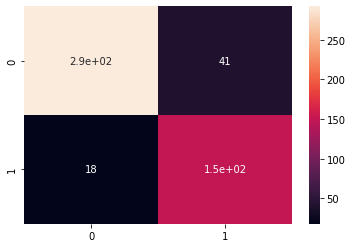

In [11]:
kacak_tahmin_modeli(model_df =  train_testData, validation_df = valData, threshold = 0.46)

In [14]:
pd.set_option('display.max_columns', 500)

In [15]:
df.describe()

,TUKETIM_M1,TUKETIM_M2,TUKETIM_M3,TUKETIM_M4,TUKETIM_M5,TUKETIM_M6,TUKETIM_M7,TUKETIM_M8,TUKETIM_M9,TUKETIM_M10,TUKETIM_M11,TUKETIM_M12,TUKETIM_M13,TUKETIM_M14,TUKETIM_M15,TUKETIM_M16,TUKETIM_M17,TUKETIM_M18,TUKETIM_M19,TUKETIM_M20,TUKETIM_M21,TUKETIM_M22,TUKETIM_M23,TUKETIM_M24,DEMAND_M1,DEMAND_M2,DEMAND_M3,DEMAND_M4,DEMAND_M5,DEMAND_M6,DEMAND_M7,DEMAND_M8,DEMAND_M9,DEMAND_M10,DEMAND_M11,DEMAND_M12,SOB_RISK_SKORU,SOKAK_RISK_SKORU,MAHALLE_RISK_SKORU,SAYAC_MALZEME_ID,SAYAC_YAPIM_YILI,NK_FLAG
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,14956.000000,14899.000000,14845.000000,14800.000000,14746.000000,14707.000000,14664.000000,14608.000000,14568.000000,14515.000000,14456.000000,14360.000000,14929.000000,12612.000000,14217.000000,12631.000000,14055.000000,12418.000000,13978.000000,12243.000000,13766.000000,12242.000000,13692.000000,11825.000000,15000.000000,15000.000000,15000.000000,1.495000e+04,14950.000000,15000.000000
mean,96.208479,205.978455,223.982149,217.158467,183.984799,184.405282,215.505007,248.644492,232.900504,205.188164,186.216120,185.762185,209.439962,211.400576,227.231838,215.400452,181.813745,185.850441,212.245346,245.245926,228.493768,187.253831,171.360149,159.670519,2.965882,3.398323,3.289800,3.142504,2.676995,2.304148,2.371124,2.434009,2.298214,2.584867,2.652326,4.903145,0.012733,0.015385,0.015423,8.000066e+07,2014.799130,0.068000
std,423.739447,806.797729,562.430605,1388.820828,1311.605920,1063.798858,1162.260886,1100.215516,1112.950045,1337.520990,815.451431,1227.890992,1574.521488,1499.281161,630.096126,767.122276,681.828994,950.896200,847.143263,754.127130,667.144225,322.313044,292.919080,290.230780,5.583334,2.748383,2.760945,2.494704,2.066277,1.930819,1.969826,2.084839,1.916677,2.020813,6.961637,204.339999,0.026829,0.135404,0.062241,3.202995e+02,2.466089,0.251754
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-159.997200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e+07,2007.000000,0.000000
25%,18.663720,67.464279,72.497774,71.253761,70.489054,72.638329,78.729780,81.960615,77.956021,74.530854,70.880832,67.422199,70.927174,68.199922,73.513714,74.332489,72.989372,75.684527,80.527145,83.570039,80.099301,74.431537,70.935518,66.885138,1.344000,1.776000,1.664000,1.612000,1.492000,1.108000,1.280000,1.084000,1.044000,1.480000,1.376000,1.592000,0.001531,0.000000,0.002672,8.000071e+07,2013.000000,0.000000
50%,57.967004,147.897623,156.901631,152.988106,136.929436,138.537125,151.135455,167.395119,156.945536,144.954876,140.683667,136.948706,147.213597,140.053495,156.308486,153.405131,139.672244,140.645618,150.976357,165.241883,157.434344,143.553273,137.515010,128.448784,2.508000,2.940000,2.812000,2.716000,2.388000,2.172000,2.232000,2.268000,2.160000,2.372000,2.304000,2.624000,0.005666,0.000000,0.006691,8.000073e+07,2015.000000,0.000000
75%,119.764778,244.215963,267.343281,251.375305,203.995790,201.954775,238.281348,288.195682,261.602692,224.807583,212.418585,210.704846,236.794562,235.207829,267.282745,252.947487,211.499773,207.428468,241.449070,287.237462,264.199954,218.611832,203.310561,188.907213,4.048000,4.816000,4.736000,4.420000,3.544000,3.016000,3.152000,3.356000,3.120000,3.384000,3.380000,4.096000,0.013746,0.010340,0.013659,8.000096e+07,2017.000000,0.000000
max,47318.985000,90851.355000,47803.770000,162381.240000,111955.470968,95467.680000,110822.519806,112852.579355,98479.082839,142768.472000,66037.545000,131526.990000,159420.555000,160152.930000,56610.225000,75857.985000,62481.510000,105136.920000,85597.155000,68889.555000,66899.385000,14361.357352,12878.880000,16314.555000,617.000000,65.428000,96.736000,66.698000,39.951000,42.688000,55.62